In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Load Dataset + fix messed up column headers
df = pd.read_csv('winequality-red-5.csv', delimiter=';', engine='python')
cols = df.columns[0]
cleaned_cols = [col.strip().strip('"') for col in cols.split(';')]

df = pd.read_csv('winequality-red-5.csv', delimiter=';', skiprows=1, header=None)
df.columns = cleaned_cols
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# Preprocesssing

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop('quality', axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y, # Preserve distribution of y within groups
    random_state=42
)

# NOTE: Random forest is scale invariant, but still scaling here so that results are comparable to those of other models
scaler = StandardScaler() # Remove mean, scale to unit variance
# fit scalar on training data + apply to both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Random Forest

## Basic Model

Random Forest Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.71      0.76      0.74       136
           6       0.65      0.71      0.68       128
           7       0.71      0.55      0.62        40
           8       0.50      0.33      0.40         3

    accuracy                           0.68       320
   macro avg       0.43      0.39      0.41       320
weighted avg       0.66      0.68      0.67       320

Accuracy: 0.68125


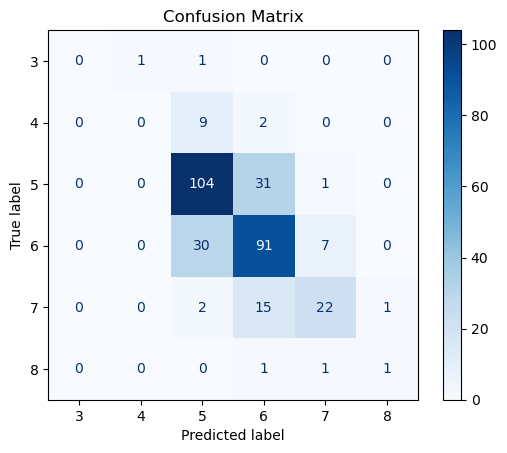

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay

rf_model = RandomForestClassifier(
    n_estimators=100, # num trees
    max_depth=None, 
    random_state=42
)

rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

ConfusionMatrixDisplay.from_estimator(rf_model, X_test_scaled, y_test, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


Notes on Terminology:
- Precision: % of predicted positives that ARE positive
- Recall: % of actual positives that WERE predicted as positive
- F1-score: Harmonic mean of precision and recall. 1 is perfect, 0 is bad.
    --> 0.6-0.7 is lowest acceptable, below that is weak
- Support: Number of true instances for each class in y_test.
- accuracy = correct pred / total pred
- macro avg = avg precision/recal/f-1 (respectively) over all classes. i.e the avgprecision is 0.29.
- weighted avg = like macro avg but takes into account # instances for each class --> helpful for imbalanced classes

Interpretation: 
- 68% of all predictions were correct
- Classes 3 and 4 were almost entirely missclassified as class 5
- Class 5 and 6 dominate the dataset, and as a result have the most accuracy. They were frequently missclassified as eachother (31 class 5's classified as 6's, 30 class 6's classified as class 5's)
- Class 8 almost entirely missclassified, but has higher results than other minority classes because 1/3 were predicted correctly. Seems to be picked up more by the model than class 4 despite class 4 having more instances, likely because class 8 is further from a dominating class so it blends in less.
- Macro averages are lower than weighed averages, again indicating class imbalance. Low generalization to minority classes.
- Weighted averages are higher ~67%, indicating stronger performance of majority classes

## Hyperparameter Tuning

Main hyper-params to consider:
- n_estimators: number of trees in the forest
- max_depth: max depth a tree can have
- min_samples_split: min number of samples that must be present in a node before the model tries to split it into smaller nodes. If node has fewer samples than this, it automatically becomes a leaf. Helps prevent overfitting by stoping tree from going too deep and learning noise of the data. Larger value = simpler tree.
- min_samples_leaf: min number of samplesthat must be present in a node for that node to be a leaf. i.e if the parent node splits and one node has less than min_samples_leaf, then that split is disallowed. This also prevents model from creating leaves that are too specific (overfitting). Can also be set as a float (a percentage of the total number of samples).

### Grid Search

In [4]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [25, 50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,   
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test_scaled)

print("Test Set Performance with Best RF:")
print(classification_report(y_test, y_pred_best))
print("Test Accuracy:", accuracy_score(y_test, y_pred_best))
print("Macro-F1:", f1_score(y_test, y_pred_best, average='macro'))

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Test Set Performance with Best RF:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.72      0.76      0.74       136
           6       0.64      0.73      0.68       128
           7       0.78      0.53      0.63        40
           8       0.00      0.00      0.00         3

    accuracy                           0.68       320
   macro avg       0.35      0.34      0.34       320
weighted avg       0.66      0.68      0.66       320

Test Accuracy: 0.68125
Macro-F1: 0.3406232296076553


### Visualizing Hyperparameter Combinations

In [5]:
# convert grid search results to a df
results_df = pd.DataFrame(grid_search.cv_results_)

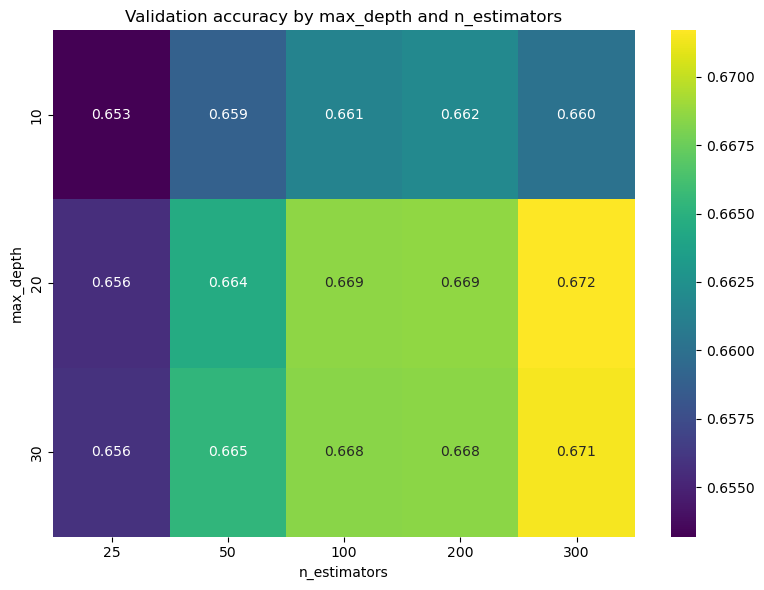

In [6]:
# create a pivot tabel to use for heat map
pivot_table = results_df.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_n_estimators'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="viridis")
plt.title("Validation accuracy by max_depth and n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()

#### Max depth vs num total trees
The accuracies here show max depth of 20 and 30 to have a slight edge over 10. For n_estimators, values of 100,200, and 300 have a slight edge. Grid search chose max depth = 20, n_estimators = 100, which we agree with because its the simplest model that achieves the highest accuracy.

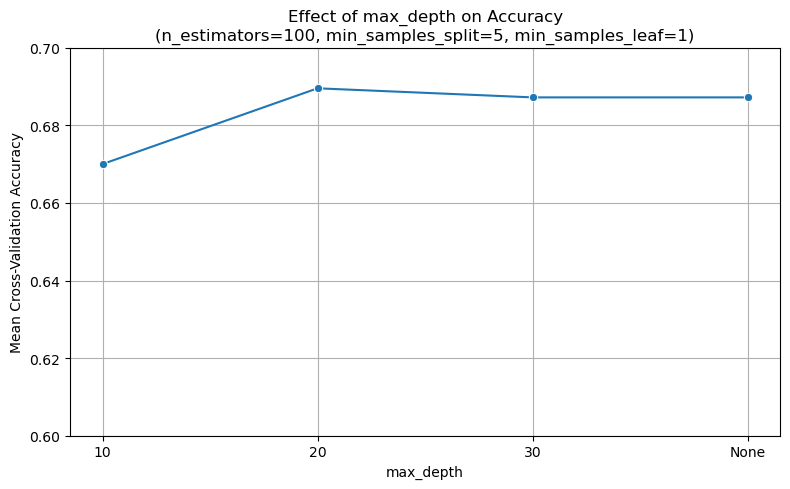

In [7]:
# hold all other params at optimal values
filtered_df = results_df[
    (results_df['param_n_estimators'] == 100) &
    (results_df['param_min_samples_split'] == 5) &
    (results_df['param_min_samples_leaf'] == 1)
]

# sort values by max_depth
filtered_df = filtered_df.sort_values(by='param_max_depth')

plt.figure(figsize=(8, 5))
sns.lineplot(
    x=filtered_df['param_max_depth'].astype(str),
    y=filtered_df['mean_test_score'],
    marker='o'
)
plt.title("Effect of max_depth on Accuracy\n(n_estimators=100, min_samples_split=5, min_samples_leaf=1)")
plt.xlabel("max_depth")
plt.ylabel("Mean Cross-Validation Accuracy")
plt.ylim(0.6, 0.7)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Max Depth alone
Here we see accuracy decrease after optimal max depth of 20.

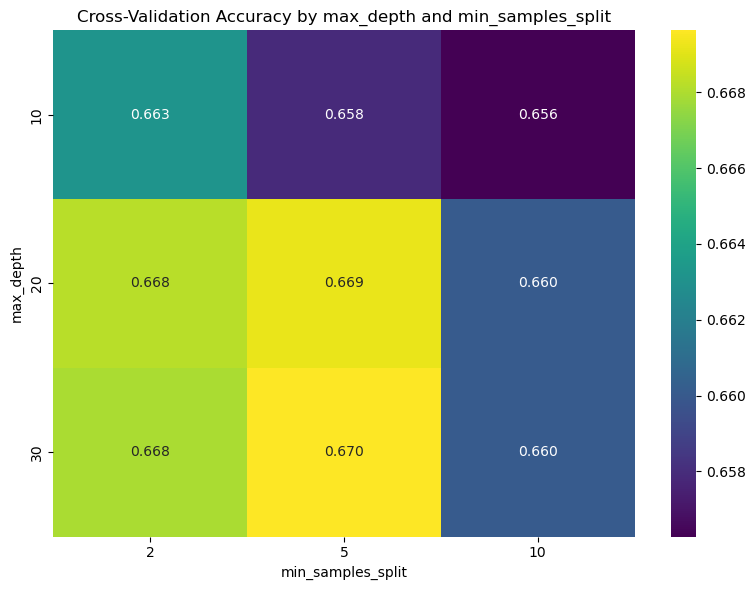

In [8]:
pivot_table2 = results_df.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_min_samples_split'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table2, annot=True, fmt=".3f", cmap="viridis")
plt.title("Cross-Validation Accuracy by max_depth and min_samples_split")
plt.xlabel("min_samples_split")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()

#### Max depth vs min samples split
Only marginal gains going from 20:5 (max_depth:min_samples_split) to 30:50, and we still choose max_depth = 20 based on the previous graphs

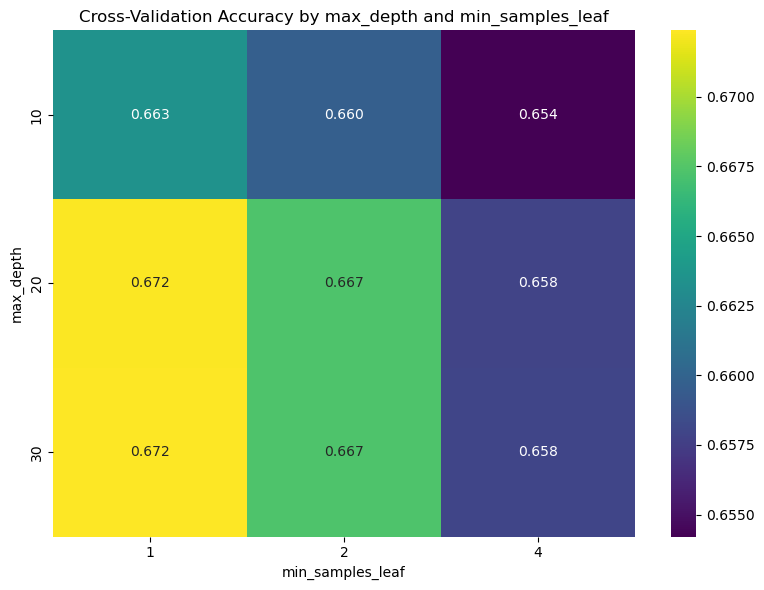

In [9]:
pivot_table3 = results_df.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_min_samples_leaf'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table3, annot=True, fmt=".3f", cmap="viridis")
plt.title("Cross-Validation Accuracy by max_depth and min_samples_leaf")
plt.xlabel("min_samples_leaf")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()

#### max depth vs min samples leaf
Here we see the optimal min samples leaf is clearly 1, and again we go with max_depth 20 based on graphs above.

#### OVERALL:
The visualizations confirm that the grid search hyperparameter values chosen are valid and not overfit. This confirms our ballpark estimate of the best parameters, but we can also try random searching for similar models that might be better. Here we can skip the fine grid search step because our course grid gives us a more conclusive estimate than in ANN where there are many more possibly valid combinations.

### Random Search in the area

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': randint(50, 501), # up to 500 trees
    'max_depth': [None] + list(range(5, 51, 5)), # none or shallow - deep
    'min_samples_split': randint(2, 21),
    'min_samples_leaf': randint(1, 5),
}

rf = RandomForestClassifier(random_state=42)
rnd_search = RandomizedSearchCV(
  estimator=rf,
  param_distributions=param_dist,
  n_iter=100,
  cv=5,
  scoring='accuracy',
  random_state=42,
  n_jobs=-1,
)

rnd_search.fit(X_train_scaled, y_train)


print("Best params from random search:", rnd_search.best_params_)
random_rf = rnd_search.best_estimator_
y_pred_random = random_rf.predict(X_test_scaled)

print("Test Set Performance with Best RF:")
print(classification_report(y_test, y_pred_random))
print("Test Accuracy:", accuracy_score(y_test, y_pred_random))
print("Macro-F1:", f1_score(y_test, y_pred_random, average='macro'))

Best params from random search: {'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 363}
Test Set Performance with Best RF:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.72      0.75      0.73       136
           6       0.63      0.75      0.68       128
           7       0.80      0.50      0.62        40
           8       0.00      0.00      0.00         3

    accuracy                           0.68       320
   macro avg       0.36      0.33      0.34       320
weighted avg       0.66      0.68      0.66       320

Test Accuracy: 0.68125
Macro-F1: 0.3387452643962027


### Comparing Chosen Models

- The grid search best model trained above and the random search beset model both have the exact same test accuracy of ~68.1%, and the random search model has slightly lower macro-f1. Random search chose a model with more trees (363 compared to 100) and chose deeper trees (25 compared to 20) with more splits (min_samples_split of 2 compared to 5). The more trees model is more complicated for the same accuracy outcome, so we will proceed with the model we got from the intial grid seaech.
- The fact that two models with very different hyperparameter lists converged on the same accuracy indivated that this is a natural ceiling for the model applied to this dataset.

# Chosen Model Details

Best parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Test Accuracy: 0.68125
Macro-F1: 0.3406232296076553
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.72      0.76      0.74       136
           6       0.64      0.73      0.68       128
           7       0.78      0.53      0.63        40
           8       0.00      0.00      0.00         3

    accuracy                           0.68       320
   macro avg       0.35      0.34      0.34       320
weighted avg       0.66      0.

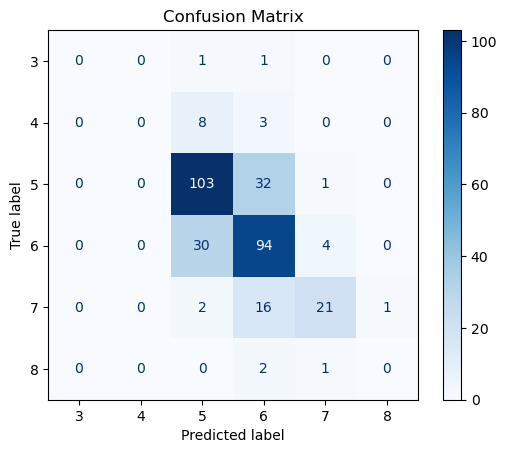

In [11]:
chosen_model = best_rf
hyperparams = chosen_model.get_params()
y_pred_final = chosen_model.predict(X_test_scaled)

print("Best parameters:", hyperparams)
print("Test Accuracy:", accuracy_score(y_test, y_pred_best))
print("Macro-F1:", f1_score(y_test, y_pred_best, average='macro'))
print(classification_report(y_test, y_pred_best))

ConfusionMatrixDisplay.from_estimator(chosen_model, X_test_scaled, y_test, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()